In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [2]:
df=pd.read_csv('creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()

False

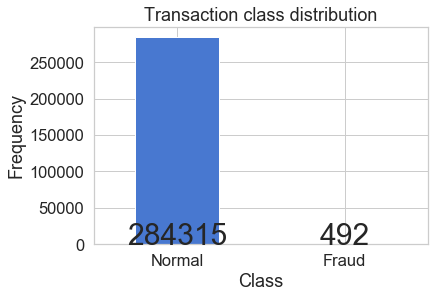

In [40]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes=df['Class'].value_counts()
count_classes.plot(kind = 'bar', rot=0)
plt.text(0,0,count_classes[0],fontsize=30,horizontalalignment='center')
plt.text(1,1,count_classes[1],fontsize=30,horizontalalignment='center')
#plt.plot(count_classes,kind='bar')
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [41]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [50]:
xtrain, xtest = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
xtrain = xtrain[xtrain.Class == 0]
xtrain = xtrain.drop(['Class'], axis=1)
ytest = xtest['Class']
xtest = xtest.drop(['Class'], axis=1)
xtrain = xtrain.values
xtest = xtest.values
xtrain.shape

(227451, 29)

In [43]:
input_dim = xtrain.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [44]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

history = autoencoder.fit(xtrain, xtrain,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(xtest, xtest),
                    verbose=1).history


Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 17s 77us/step - loss: 0.8115 - accuracy: 0.6003 - val_loss: 0.7896 - val_accuracy: 0.6520
Epoch 2/100
227451/227451 [==============================] - 15s 66us/step - loss: 0.7545 - accuracy: 0.6510 - val_loss: 0.7780 - val_accuracy: 0.6518
Epoch 3/100
227451/227451 [==============================] - 15s 67us/step - loss: 0.7443 - accuracy: 0.6497 - val_loss: 0.7696 - val_accuracy: 0.6483
Epoch 4/100
227451/227451 [==============================] - 15s 66us/step - loss: 0.7363 - accuracy: 0.6509 - val_loss: 0.7635 - val_accuracy: 0.6640
Epoch 5/100
227451/227451 [==============================] - 14s 63us/step - loss: 0.7320 - accuracy: 0.6557 - val_loss: 0.7674 - val_accuracy: 0.6441
Epoch 6/100
227451/227451 [==============================] - 14s 63us/step - loss: 0.7295 - accuracy: 0.6599 - val_loss: 0.7597 - val_accuracy: 0.6677
Epoch 7/100
227451/227451 [===============

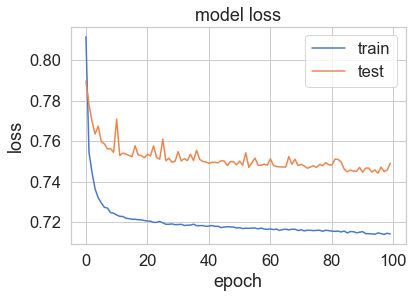

In [45]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [47]:
predictions = autoencoder.predict(xtest)

In [48]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [55]:
mse = np.mean(np.power(xtest - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': ytest})

In [ ]:
pred=(predictions >0.5)
ytest=ytest.astype('float64')
confusion_matrix(ytest,predictions,normalize=False )

In [62]:
threshold = 2.9

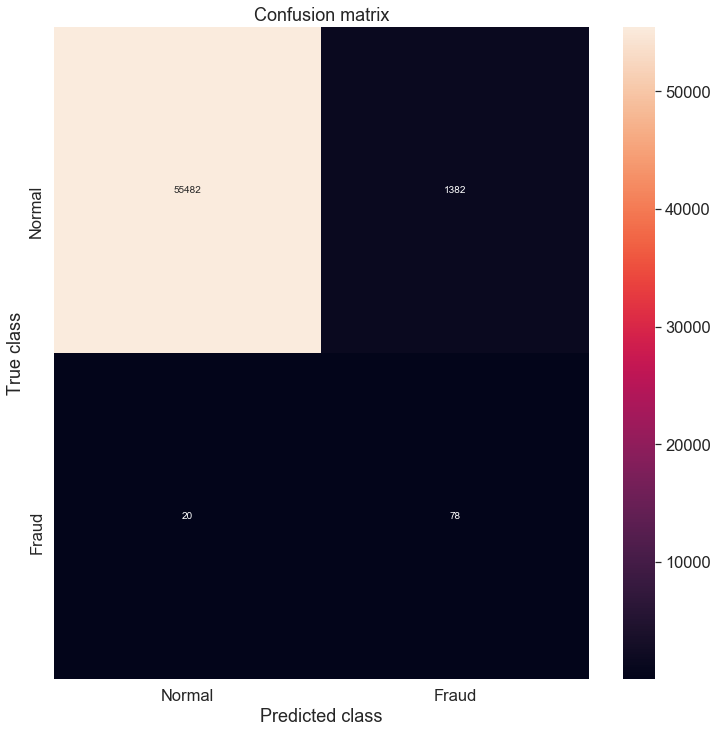

In [63]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()